<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C3/C3.html"><img src="../data/C3_nav.png" width="100"  style="float:right;" alt="C3"></a>
<h1>Logarithmic Compression</h1> 
</div>

<br/>

<p>
Following Section 3.1.2.1 of <a href="http://www.music-processing.de">[Müller, FMP, Springer 2015]</a>, we introduce in this notebook the concept of logarithmic compression.
</p> 

## Compression Function

In music signal processing, the problem with representations such as a spectrogram or chromagram is that its values possess a large dynamic range. As a result, small, but still relevant values may be dominated or obscured by large values. Therefore, one often uses a [**decibel scale**](../C1/C1S3_Dynamics.html), where the idea is to balance out this discrepancy by reducing the difference between large and small values with the effect of enhancing the small values. More generally, one may apply other types of logarithm-based functions, a step often referred to as **logarithmic compression**. Let $\gamma\in\mathbb{R}_{>0}$ be a positive constant, then we define a function $\Gamma_\gamma:\mathbb{R}_{>0} \to \mathbb{R}_{>0}$ by

\begin{equation}
   \Gamma_\gamma(v):=\log(1+ \gamma \cdot v)
\end{equation}

for some positive value $v\in\mathbb{R}_{>0}$. Opposed to the $\mathrm{dB}$ function, the function $\Gamma_\gamma$ yields a positive value $\Gamma_\gamma(v)$ for any positive value $v\in\mathbb{R}_{>0}$. The degree of compression can be adjusted by the constant $\gamma$: the larger $\gamma$, the larger the resulting compression. The following code cell illustrates the compression function $\Gamma_\gamma$ for different constants $\gamma$.

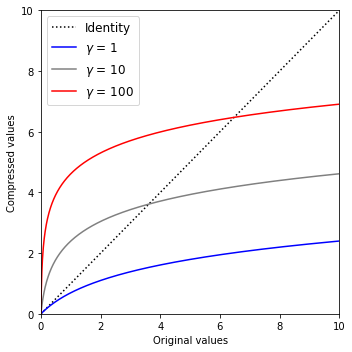

In [1]:
import os 
import numpy as np
from matplotlib import pyplot as plt
import librosa, librosa.display
from numba import jit
%matplotlib inline

v = np.arange(1001) / 100

@jit(nopython=True)
def log_compression(v, gamma=1.0):
    """Logarithmically compresses a value or array

    Notebook: C3/C3S1_LogCompression.ipynb

    Args:
        v (float or np.ndarray): Value or array
        gamma (float): Compression factor (Default value = 1.0)

    Returns:
        v_compressed (float or np.ndarray): Compressed value or array
    """
    return np.log(1 + gamma * v)


plt.figure(figsize=(5, 5))
plt.plot(v, v, color='black', linestyle=':', label='Identity')
plt.plot(v, log_compression(v, gamma=1), color='blue', label='$\gamma$ = 1')
plt.plot(v, log_compression(v, gamma=10), color='gray', label='$\gamma$ = 10')
plt.plot(v, log_compression(v, gamma=100), color='red', label='$\gamma$ = 100')
plt.xlabel('Original values')
plt.ylabel('Compressed values')
plt.xlim([v[0], v[-1]])
plt.ylim([v[0], v[-1]])
# plt.tick_params(direction='in')
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()


## Compressed Spectrogram

For a representation with positive values such as a spectrogram, one obtains a compressed version by applying the function $\Gamma_\gamma$ to each of the values. For example, for a [spectrogram](../C2/C2_STFT-Basic.html) $\mathcal{Y}$, the compressed version is the concatenation $\Gamma_\gamma \circ \mathcal{Y}$ defined by 

\begin{equation}
   (\Gamma_\gamma\circ \mathcal{Y})(n,k):=\log(1+ \gamma \cdot \mathcal{Y}(n,k))
\end{equation}

with $n$ being the time frame parameter and $k$ the frequency bin parameter. A suitable choice of $\gamma$ very much depends on the data characteristics and the application in mind. In particular, in the presence of noise one needs to find a good balance between enhancing the weak but relevant signal components while not amplifying the undesired noise components too much. As an illustrating example, we consider a recording of the note C4 played by a piano. The following figure shows the resulting spectrogram as well as compressed versions using different constants $\gamma$.

<audio src="../data/C3/FMP_C3_NoteC4_Piano.wav" type="audio/mpeg" controls="controls"></audio>

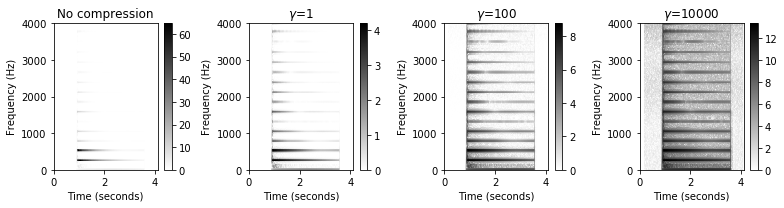

In [2]:
x, Fs = librosa.load(os.path.join('..', 'data', 'C3', 'FMP_C3_NoteC4_Piano.wav'))

N = 1024
H = 512
X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann', pad_mode='constant', center=True)
T_coef = np.arange(X.shape[1]) * H / Fs
K = N // 2
F_coef = np.arange(K + 1) * Fs / N
Y = np.abs(X) ** 2

plt.figure(figsize=(11, 3))
extent = [T_coef[0], T_coef[-1], F_coef[0], F_coef[-1]]
gamma_set = [0, 1, 100, 10000]
M = len(gamma_set)
Y = np.abs(X)

for m in range(M):
    ax = plt.subplot(1, M, m + 1)
    gamma = gamma_set[m]
    if gamma == 0:
        Y_compressed = Y
        title = 'No compression'
    else:
        Y_compressed = log_compression(Y, gamma=gamma)
        title = '$\gamma$=%d' % gamma
    plt.imshow(Y_compressed, cmap='gray_r', aspect='auto', origin='lower', extent=extent)
    plt.xlabel('Time (seconds)')
    plt.ylim([0, 4000])
    plt.clim([0, Y_compressed.max()])
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.title(title)

plt.tight_layout()

While the partials (the horizontal lines) are hardly visible in the original spectrogram, they clearly pop up in the compressed versions. Also, the note transient (the vertical line at time position $t=0.9$) emerges when increasing the constant $\gamma$. As a downside, noise-like sound components are also enhanced when compressing the spectrogram. A suitable choice of $\gamma$ very much depends on the data characteristics and the application in mind. In particular, in the presence of noise one needs to find a good balance between enhancing the weak but relevant signal components while not amplifying the undesired noise components too much.

## Compressed Chromagram

Next, we consider a [chromagram](../C3/C3S1_SpecLogFreq-Chromagram.html) $\mathcal{C}$ and its compressed version $\Gamma_\gamma \circ \mathcal{C}$ defined by 

\begin{equation}
   (\Gamma_\gamma\circ \mathcal{C})(n,c):=\log(1+ \gamma \cdot \mathcal{C}(n,c)). 
\end{equation}

As an example, we consider a piano recording of a C major scale.

<img src="../data/C3/FMP_C3_F08a.png" width="400px" align="left" alt="C1">

<br clear="all" />

<audio src="../data/C3/FMP_C3_F08_C-major-scale_pause.wav" type="audio/mpeg" controls="controls"></audio>

The following figure shows a chromagram as well as compressed versions using different constants $\gamma$.

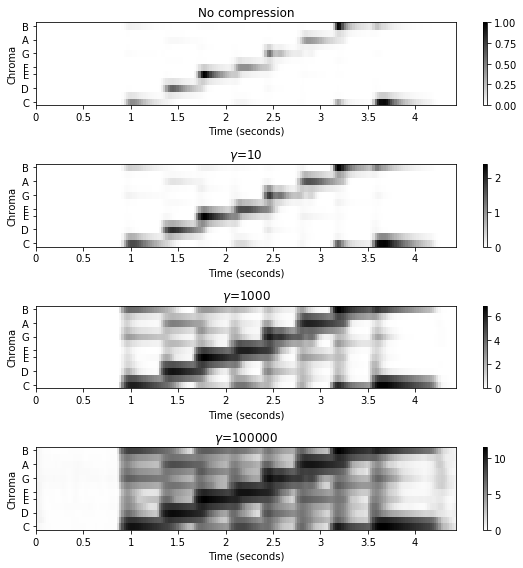

In [3]:
Fs = 22050
fn_wav = os.path.join('..', 'data', 'C3', 'FMP_C3_F08_C-major-scale_pause.wav')
x, Fs = librosa.load(fn_wav, sr=Fs)

N = 4096
H = 512
C = librosa.feature.chroma_stft(y=x, sr=Fs, tuning=0, norm=None, hop_length=H, n_fft=N)
C = C / C.max()

plt.figure(figsize=(8, 8))
gamma_set = [0, 10, 1000, 100000]
M = len(gamma_set)
Y = np.abs(X)

for m in range(M):
    ax = plt.subplot(M, 1, m + 1)
    gamma = gamma_set[m]
    if gamma == 0:
        C_compressed = C
        title = 'No compression'
    else:
        C_compressed = log_compression(C, gamma=gamma)
        title = '$\gamma$=%d' % gamma
    librosa.display.specshow(C_compressed, x_axis='time', 
                             y_axis='chroma', cmap='gray_r', sr=Fs, hop_length=H)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Chroma')
    plt.clim([0, np.max(C_compressed)])
    plt.title(title)
    plt.colorbar()

plt.tight_layout()

## Further Notes

* Logarithmic compression is a simple, yet powerful tool that is widely used for various music processing tasks. We use this concept throughout the FMP notebooks. A prominent example is the [FMP notebook on chord recognition)](../C5/C5S3_ChordRec_Beatles.html), which presents a case study based on the Beatles corpus to investigates how different chroma variants effect chord recognition results.

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a>.
</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>